# Generative Adversarial Network for simple sinusoidal data
Following the example from: <br>
https://realpython.com/generative-adversarial-networks/

In [1]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt

In [2]:
# generate random seed
torch.manual_seed(111)

### Prepare training data

In [3]:
# The training data is composed of pairs (x₁, x₂) so that x₂
# consists of the value of the sine of x₁ for x₁ in the interval from 0 to 2π.

train_data_length = 1024
train_data = torch.zeros((train_data_length, 2))
train_data[:, 0] = 2 * math.pi * torch.rand(train_data_length)
train_data[:, 1] = torch.sin(train_data[:, 0])
train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]

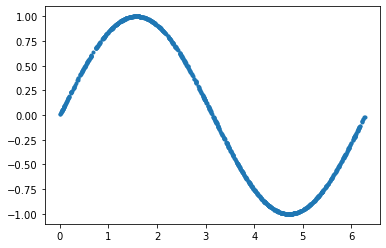

In [5]:
plt.plot(train_data[:, 0], train_data[:, 1], ".")

In [6]:
# create a python dataloader
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)